# Proyek Klasifikasi Gambar: 10 Jenis Hewan (Dataset Animals-10)

- Nama: Bimoseno Kuma
- Email: kuma24@student.ub.ac.id
- ID Dicoding: kukuma

## Import Semua Packages/Library yang Digunakan

In [2]:
import os
import sys
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import subprocess
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import splitfolders

In [3]:
# Setup GPU sebelum import TensorFlow (untuk Windows dengan conda)
print("="*70)
print("SETUP GPU CONFIGURATION")
print("="*70)

# Set environment variables untuk GPU
conda_prefix = os.environ.get('CONDA_PREFIX', '')
if conda_prefix:
    conda_bin = os.path.join(conda_prefix, 'Library', 'bin')
    os.environ['PATH'] = conda_bin + os.pathsep + os.environ.get('PATH', '')
    os.environ['CUDA_HOME'] = conda_prefix
    os.environ['CUDA_PATH'] = conda_prefix
    print(f"CUDA paths set from conda: {conda_prefix}")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Reduce TF logging
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use GPU 0
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Check GPU availability
print(f"\nPython version: {sys.version}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✓ GPU is available!")
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"  - {gpu}")
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(f"Memory growth setting error: {e}")
else:
    print("✗ GPU is not available, using CPU")
    print("Note: Training will be slower on CPU")

print("="*70)


SETUP GPU CONFIGURATION
CUDA paths set from conda: D:\anaconda3\envs\python37

Python version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.11.0
Num GPUs Available: 0
✗ GPU is not available, using CPU
Note: Training will be slower on CPU


### Data Loading

In [4]:
# Setup Kaggle API
home_dir = os.path.expanduser("~")
kaggle_dir = os.path.join(home_dir, ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Copy kaggle.json to ~/.kaggle/
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
local_kaggle_json = "kaggle.json"

# Set permissions (for Unix/Linux/Mac)
if os.name != 'nt':
    os.chmod(kaggle_json_path, 0o600)

# Download dataset
print("\nDownloading dataset from Kaggle...")
current_dir = os.getcwd()

# Check if dataset already exists
if os.path.exists('raw-img'):
    print("Dataset 'raw-img' already exists. Skipping download.")
else:
    try:
        # Try using kaggle API directly
        import kaggle
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files('alessiocorrado99/animals10', 
                                         path=current_dir, 
                                         unzip=True)
        print("Dataset downloaded successfully using Kaggle API!")
    except Exception as e:
        print(f"Kaggle API error: {e}")
        print("Trying command line download...")
        try:
            result = subprocess.run(['kaggle', 'datasets', 'download', 
                                   '-d', 'alessiocorrado99/animals10', 
                                   '-p', current_dir, '--unzip'], 
                                  capture_output=True, text=True)
            if result.returncode == 0:
                print("Dataset downloaded successfully!")
            else:
                print(f"Download error: {result.stderr}")
        except Exception as e:
            print(f"Command line download failed: {e}")

print("\nDataset berhasil diunduh dan diekstrak.")



Dataset 'raw-img' already exists. Skipping download.

Dataset berhasil diunduh dan diekstrak.


### Data Preprocessing

#### Split Dataset

In [5]:
# Path input dan output
input_folder = os.path.join(current_dir, 'raw-img')
output_folder = os.path.join(current_dir, 'dataset_split')

# Check if input folder exists
if not os.path.exists(input_folder):
    print(f"Error: Folder '{input_folder}' tidak ditemukan!")
    print("Pastikan dataset sudah didownload dan diekstrak.")
    sys.exit(1)

# Hapus folder output jika sudah ada untuk memastikan kebersihan
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
    print(f"Removed existing {output_folder}")

# Lakukan pembagian dengan rasio 80:10:10
print("\nSplitting dataset into train/val/test...")
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

print(f"Dataset berhasil dibagi ke dalam folder: {output_folder}")
print(f"Isi folder output: {os.listdir(output_folder)}")

Removed existing c:\Users\GL503\Downloads\bimo\dataset_split

Splitting dataset into train/val/test...


Copying files: 26179 files [00:59, 441.10 files/s]

Dataset berhasil dibagi ke dalam folder: c:\Users\GL503\Downloads\bimo\dataset_split
Isi folder output: ['test', 'train', 'val']


In [6]:
# Tentukan path direktori yang sudah dibagi
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

# Ukuran gambar yang akan digunakan untuk model
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

# Generator untuk data latih dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan tes (hanya normalisasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Buat flow dari direktori
print("\nCreating data generators...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Dapatkan nama kelas
class_names = list(train_generator.class_indices.keys())
print(f"\nNama kelas yang ditemukan: {class_names}")
print(f"Jumlah kelas: {len(class_names)}")


Creating data generators...
Found 20938 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.

Nama kelas yang ditemukan: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Jumlah kelas: 10


## Modelling

In [7]:
# Device placement
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    # Membangun arsitektur model
    model = Sequential([
        # Blok Konvolusi 1
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Blok Konvolusi 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Blok Konvolusi 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Blok Konvolusi 4
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        # Flatten layer untuk mengubah menjadi 1D
        Flatten(),

        # Lapisan Dense
        Dense(512, activation='relu'),
        Dropout(0.5),

        # Lapisan Output
        Dense(len(class_names), activation='softmax') # Jumlah neuron sesuai jumlah kelas
    ])

# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Tampilkan ringkasan model
print("\nModel Summary:")
model.summary()

Using device: /CPU:0

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                   

## Evaluasi dan Visualisasi

In [8]:
# Definisikan callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [9]:
# Tentukan jumlah epoch
EPOCHS = 50

print(f"\nStarting training for {EPOCHS} epochs...")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

# Latih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)




Starting training for 50 epochs...
Training samples: 20938
Validation samples: 2614
Epoch 1/50
654/654 [==============================] - ETA: 0s - loss: 2.4561 - accuracy: 0.2607
Epoch 1: val_accuracy improved from -inf to 0.30440, saving model to best_model.h5
654/654 [==============================] - 589s 892ms/step - loss: 2.4561 - accuracy: 0.2607 - val_loss: 1.9017 - val_accuracy: 0.3044 - lr: 0.0010
Epoch 2/50
654/654 [==============================] - ETA: 0s - loss: 1.9129 - accuracy: 0.3369
Epoch 2: val_accuracy improved from 0.30440 to 0.36381, saving model to best_model.h5
654/654 [==============================] - 442s 675ms/step - loss: 1.9129 - accuracy: 0.3369 - val_loss: 1.8411 - val_accuracy: 0.3638 - lr: 0.0010
Epoch 3/50
654/654 [==============================] - ETA: 0s - loss: 1.8244 - accuracy: 0.3749
Epoch 3: val_accuracy improved from 0.36381 to 0.42901, saving model to best_model.h5
654/654 [==============================] - 445s 681ms/step - loss: 1.8244 - 


Plotting training history...


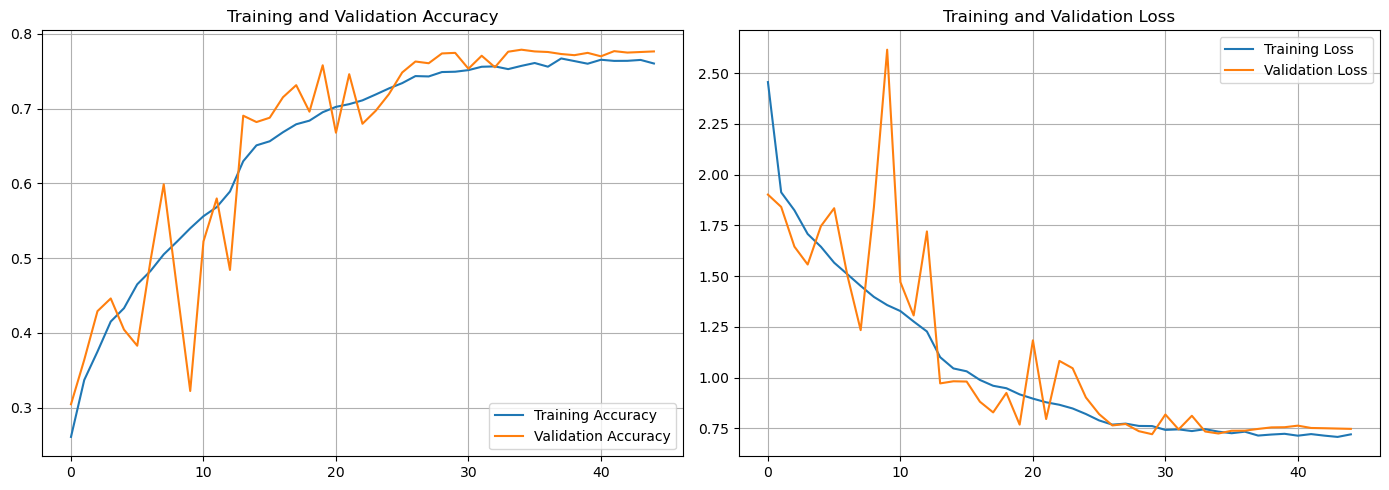

In [10]:
# Plot akurasi dan loss
print("\nPlotting training history...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


Mengevaluasi model pada data tes...
83/83 [==============================] - 30s 360ms/step - loss: 0.7291 - accuracy: 0.7689

Akurasi pada data tes: 76.89%
Loss pada data tes: 0.7291

Generating predictions...
83/83 [==============================] - 15s 173ms/step

Classification Report:
              precision    recall  f1-score   support

        cane       0.86      0.68      0.76       487
     cavallo       0.70      0.78      0.74       263
    elefante       0.58      0.85      0.69       146
    farfalla       0.81      0.88      0.85       212
     gallina       0.76      0.90      0.82       311
       gatto       0.82      0.53      0.64       168
       mucca       0.69      0.57      0.62       188
      pecora       0.64      0.76      0.70       182
       ragno       0.91      0.86      0.88       483
  scoiattolo       0.73      0.76      0.74       187

    accuracy                           0.77      2627
   macro avg       0.75      0.76      0.74      2627
weig

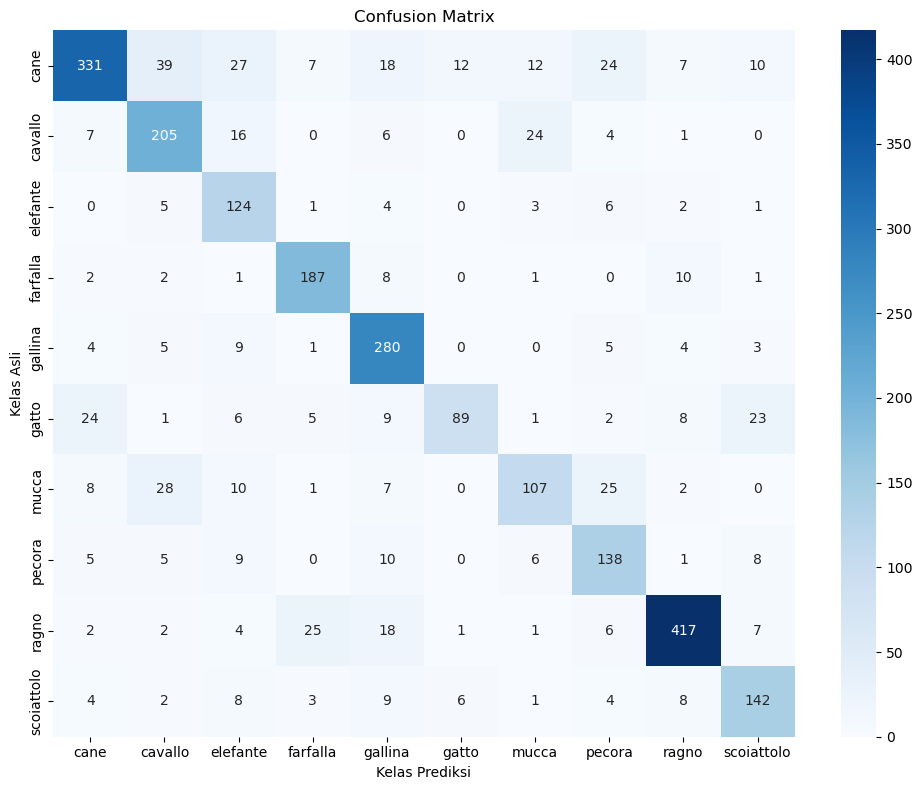

In [11]:
# Muat model terbaik yang disimpan oleh ModelCheckpoint
model.load_weights('best_model.h5')

# Evaluasi pada data tes
print("\nMengevaluasi model pada data tes...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f'\nAkurasi pada data tes: {test_acc*100:.2f}%')
print(f'Loss pada data tes: {test_loss:.4f}')

# Prediksi untuk classification report dan confusion matrix
print("\nGenerating predictions...")
Y_pred = model.predict(test_generator, steps=np.ceil(test_generator.samples/BATCH_SIZE))
y_pred_classes = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Laporan Klasifikasi
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Kelas Asli')
plt.xlabel('Kelas Prediksi')
plt.tight_layout()
plt.show()

## Konversi Model

In [12]:
# Membuat direktori untuk menyimpan model
os.makedirs('saved_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('tfjs_model', exist_ok=True)

# 1. Simpan ke format SavedModel
model.save('saved_model/animals_model')
print("✓ Model berhasil disimpan dalam format SavedModel.")

# 2. Konversi ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('tflite/animals_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("✓ Model berhasil dikonversi ke format TF-Lite.")

# 3. Konversi ke format TFJS
print("Installing tensorflowjs...")
try:
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'tensorflowjs', '--quiet'], check=True)
    
    # Lakukan konversi
    print("Converting to TensorFlow.js format...")
    result = subprocess.run(['tensorflowjs_converter', '--input_format=keras', 
                           'saved_model/animals_model', 'tfjs_model/'], 
                          capture_output=True, text=True)
    if result.returncode == 0:
        print("✓ Model berhasil dikonversi ke format TFJS.")
    else:
        print(f"✗ Error converting to TFJS: {result.stderr}")
except Exception as e:
    print(f"✗ TFJS conversion failed: {e}")



INFO:tensorflow:Assets written to: saved_model/animals_model\assets


INFO:tensorflow:Assets written to: saved_model/animals_model\assets


✓ Model berhasil disimpan dalam format SavedModel.


INFO:tensorflow:Assets written to: C:\Users\GL503\AppData\Local\Temp\tmpievo_hh2\assets


INFO:tensorflow:Assets written to: C:\Users\GL503\AppData\Local\Temp\tmpievo_hh2\assets


✓ Model berhasil dikonversi ke format TF-Lite.
Installing tensorflowjs...
Converting to TensorFlow.js format...
✗ Error converting to TFJS: Traceback (most recent call last):
  File "c:\Users\GL503\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\Users\GL503\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\GL503\AppData\Local\Programs\Python\Python37\Scripts\tensorflowjs_converter.exe\__main__.py", line 7, in <module>
  File "C:\Users\GL503\AppData\Roaming\Python\Python37\site-packages\tensorflowjs\converters\converter.py", line 813, in pip_main
    main([' '.join(sys.argv[1:])])
  File "C:\Users\GL503\AppData\Roaming\Python\Python37\site-packages\tensorflowjs\converters\converter.py", line 817, in main
    convert(argv[0].split(' '))
  File "C:\Users\GL503\AppData\Roaming\Python\Python37\site-packages\tensorflowjs\converters\converter.py", 

## Inference (Optional)

In [13]:
print("\nPerforming inference test...")

# Muat kembali model SavedModel (contoh)
loaded_model = tf.keras.models.load_model('saved_model/animals_model')

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi
    return img_array

# Pilih kelas acak dan gambar acak dari data tes
random_class = random.choice(class_names)
random_class_path = os.path.join(test_dir, random_class)
random_image_name = random.choice(os.listdir(random_class_path))
test_image_path = os.path.join(random_class_path, random_image_name)

# Proses gambar dan lakukan prediksi
processed_img = load_and_preprocess_image(test_image_path)
prediction = loaded_model.predict(processed_img)
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(prediction) * 100


Performing inference test...
1/1 [==============================] - 0s 198ms/step


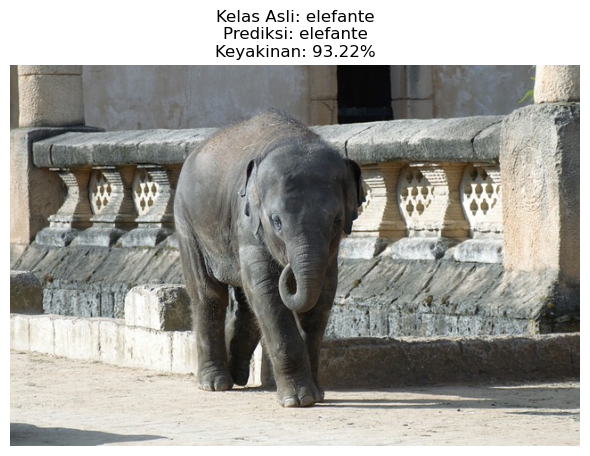


--- BUKTI INFERENSI ---
Gambar yang diuji: c:\Users\GL503\Downloads\bimo\dataset_split\test\elefante\ea34b10e2df1043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg
Kelas Sebenarnya: elefante
Hasil Prediksi Model: elefante
Tingkat Keyakinan: 93.22%

TRAINING COMPLETED SUCCESSFULLY!
Total parameters: 6,818,506
Training samples: 20938
Validation samples: 2614
Test samples: 2627
Final test accuracy: 76.89%
Device used: /CPU:0

Model saved in:
- saved_model/animals_model (SavedModel format)
- tflite/animals_model.tflite (TensorFlow Lite)
- tfjs_model/ (TensorFlow.js)

Plots saved:
- training_history.png
- confusion_matrix.png
- inference_example.png


In [14]:
# Tampilkan hasil
plt.figure(figsize=(6, 6))
img = Image.open(test_image_path)
plt.title(f"Kelas Asli: {random_class}\nPrediksi: {predicted_class_name}\nKeyakinan: {confidence:.2f}%")
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.savefig('inference_example.png', dpi=300)
plt.show()

print("\n--- BUKTI INFERENSI ---")
print(f"Gambar yang diuji: {test_image_path}")
print(f"Kelas Sebenarnya: {random_class}")
print(f"Hasil Prediksi Model: {predicted_class_name}")
print(f"Tingkat Keyakinan: {confidence:.2f}%")

# Summary
print("\n" + "="*70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"Total parameters: {model.count_params():,}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Final test accuracy: {test_acc*100:.2f}%")
print(f"Device used: {device}")
print("\nModel saved in:")
print("- saved_model/animals_model (SavedModel format)")
print("- tflite/animals_model.tflite (TensorFlow Lite)")
print("- tfjs_model/ (TensorFlow.js)")
print("\nPlots saved:")
print("- training_history.png")
print("- confusion_matrix.png")
print("- inference_example.png")
